In [1]:
import numpy as np
from matplotlib import pyplot as plt

# for building the animation
import os
import imageio

# for doing the convolution
from numpy.fft import fft2, ifft2

# Defining Some Useful Functions

In [2]:
def mesh_builder(n, mesh_size):
    #this mesh works as the mass distribution
    #build a square mesh for the points (mesh_size * mesh_size)
    #n is the number of points
    
    m = np.zeros((mesh_size, mesh_size))
    counter = 0
    
    #putting n random points in the mesh (where there is a object: m=1, where none: m=0)
    while(True):
        a = int(mesh_size* np.random.random())
        b = int(mesh_size* np.random.random())
            
        if m[a,b] == 0:
            m[a,b] = 1
            counter += 1
                
        if counter == n:
            break
     
    print ('total number of points is : ' + repr(counter))  
        
    return m


def mesh_to_xy(m, n):
    #building the xy from the mesh
    #x[:, 0] showing the x component of locations
    #x[:, 1] showing the y component of locations
    #x: [n,2]
    b = np.shape(m)
    mesh_size= b[0]
          
    xy = np.zeros((n,2))
    counter = 0
    for i in range (mesh_size):
        for j in range(mesh_size):
            if m[i,j]== 1:
                xy[counter, 0] = i
                xy[counter, 1] = j
                counter +=1
                    
    return xy

def xy_to_mesh(xy, mesh_size):
    #building the mesh from xy
    b=np.shape(xy)
    n= b[0]
    
    m=np.zeros((mesh_size, mesh_size))
    for i in range(n):
        x= int(xy[i, 0])
        y=int(xy[i, 1])
        m[x, y]= 1
        
    return m
       
    
def point_charge_pot(mesh_size, r0):
    #r0=1
    #calculates the softend potential from a point charge on a 2D mesh of size (mesh_size * mesh_size)
    #r0 is the radius of softening

    
    dx = np.zeros((mesh_size, mesh_size))
    dy = np.zeros((mesh_size, mesh_size))
    r= np.zeros((mesh_size, mesh_size))
    pot_2D = np.zeros((mesh_size, mesh_size))
    
    #place of the point charge
    c = int(mesh_size/2)
    
    for i in range(mesh_size):
        for j in range(mesh_size):
            dx[i, j]= abs(i- c)
            dy[i, j]= abs(j- c)
            r[i, j]= np.sqrt(dx[i,j]**2 + dy[i,j]**2)
            if r[i, j] < r0 :
                r[i,j]= r0
             
            #potential is: - 1 / r
            pot_2D[i,j] = -1 * (r[i,j]** -1)
            
    return pot_2D

def potential_calc(m, r0):
    #calculates the potential of a mass distribution
    #by convolving the potential of a point charge with the mass density (mesh)
    
    b=np.shape(m)
    mesh_size= b[0]
    
    rho = m
    pot= point_charge_pot(mesh_size, r0)
    
    ft1= fft2(rho)
    ft2= fft2(pot)
    
    return np.real(ifft2(ft1 * ft2)) 

def force_calc(pot):
    # force = - gradiant(potential)
    f_x, f_y= np.gradient(pot)
    f_x = -1 *f_x
    f_y = -1 *f_y
    return 1000*f_x, 1000*f_y

def f_change(xy, fx, fy, n):
    #to change the shape of the force from (m*m) to (n, 2)

    f = np.zeros((n, 2))
    for i in range(n):
        x= int(xy[i, 0])
        y= int(xy[i, 1])
        f[i, 0]= fx[x, y]
        f[i, 1]= fy[x, y]

    return f

def p_change(xy, p, n):
    #to change the shape of the potential from (m*m) to (n, 1)
    # only having the potential for meshs with a point
    #and to calculate the potential from all particles
    p_new = np.zeros((n, 1))
    for i in range(n):
        x= int(xy[i, 0])
        y= int(xy[i, 1])
        p_new[i]= p[x, y]
        p_tot = np.sum(p_new)

    return p_tot

def kin_calc(v, n):
    #shape of v is (n,2)
    #to calculate the kintetic energy of all particles
    kin = np.zeros((n))
    for i in range (n):
        kin[i] = (v[i, 0]**2 + v[i, 1]**2)
        
    kin_tot = np.sum (kin)
    return kin_tot

# Checking the functions

total number of points is : 5


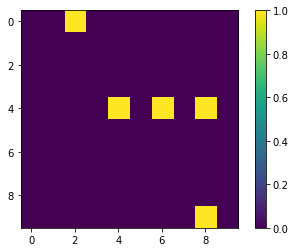

In [3]:
#checking the mesh_builder function
a= mesh_builder(5, 10)
plt.imshow(a)
plt.colorbar()
plt.show()

In [4]:
#to check if mesh_to_xy and xy_to_mesh works fine
#If the result is "True", they work well
a= mesh_builder(5, 10)
b = mesh_to_xy(a, 5)
c = xy_to_mesh(b, 10)

comparison = a == c
equal_arrays = comparison.all()

print(equal_arrays)

total number of points is : 5
True


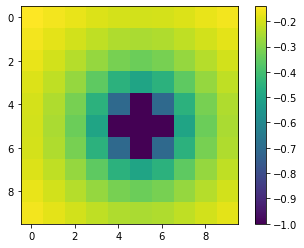

In [5]:
#to check if the potential of a point charge is built correctly
a= point_charge_pot(10, 1)
plt.imshow(a)
plt.colorbar()
plt.show()
#print(a)

total number of points is : 1


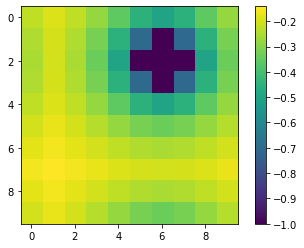

In [6]:
#to check if the whole potential is built correctly
a = potential_calc(mesh_builder(1, 10), 1)
plt. imshow(a)
plt.colorbar()
plt.show()
#print (a)

total number of points is : 10
(10, 10)


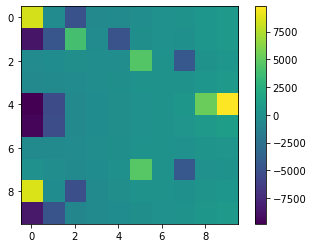

In [7]:
#to check if forces are built correctly
fx, fy= force_calc(potential_calc(mesh_builder(10, 10), 0.1))
print(np.shape(fx))
plt.imshow(fy)
plt.colorbar()
plt.show()

In [8]:
#to check the force change
f= f_change(mesh_to_xy(mesh_builder(10, 10), 10), fx, fy, 10)
print(np.shape(f))

total number of points is : 10
(10, 2)


In [9]:
class particles:
    def __init__(self, n, r0, mesh_size, dt):
        #mesh size should be bigger than sqrt(n)
        
        self.n=n
        self.mesh_size= mesh_size
        self.r0 = r0 
        self.dt = dt
        
        self.xy = mesh_to_xy(mesh_builder(self.n, self.mesh_size), self.n)
    
        #force and velocity
        self.v= np.zeros((self.n,2))
        self.fx= np.zeros((self.mesh_size, self.mesh_size))
        self.fy= np.zeros((self.mesh_size, self.mesh_size))
        
    def update(self):
    #updates the places and velocity
    
        #updating the places
           
        self.xy = self.xy+ self.v*self.dt
        #print(self.xy)
        #finding the first kin
        kin1 = kin_calc(self.v , self.n)
        #print('kin1: '+ repr(kin1))
                  
        #updating the velocity
                  
        f = f_change(self.xy, self.fx, self.fy, self.n)

        self.v = self.v + f * self.dt

        #finding the second kin    
        
        kin2 = kin_calc(self.v , self.n)
        #print('kin2: '+ repr(kin2))
        
        #updating the force
        m = xy_to_mesh(self.xy, self.mesh_size)
        p = potential_calc(m, self.r0)
        pot = p_change(self.xy, p, self.n)
        self.fx, self.fy = force_calc(p)

        #combining kins
        kin = 0.5 * (kin1 + kin2)

        #finding the total energy
        energy_t = pot + kin
        #print('shape pot' + repr(np.shape(pot)))
        #print('shape kin' + repr(np.shape(kin)))  
        #print (pot, kin, energy_t)

        return pot/self.n, kin/(self.n), (kin+pot)/(self.n)

In [10]:
parts=particles(n=1000, r0= 1, mesh_size= 200, dt=3e-4)
plt.ion()
nstep=500
pot = kin = e_t = np.zeros((nstep))
a=open('energy_new.txt','w')
filenames = []
for i in range(nstep):
    plt.clf()
    plt.plot(parts.xy[:,0],parts.xy[:,1],'.')
    filename = f'{i}.png'
    filenames.append(filename)
    
    # save frame
    plt.savefig(filename)
    plt.close()
    #plt.pause(0.001)
    
    pot[i], kin[i], e_t[i] =parts.update()
    a.write('   Kintetic: '+ repr(kin[i]) +'        Potential: '+ repr(pot[i]) + '       Total Energy: '+ repr(e_t[i])+ '\n') 
    
a.close()
    
# build gif
with imageio.get_writer('particle.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# Remove files
for filename in set(filenames):
    os.remove(filename)
    

total number of points is : 1000


IndexError: index 200 is out of bounds for axis 1 with size 200